In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap

from tapm import miscellanea as msc
#from miscellanea import *
from tapm import utils

ERROR:tapm.HIVandSTI.model_HIVandSTI:y_0 does not add up to 1 for HIV.
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


## Code to generate data for website plots

In [7]:
import numpy as np
import json

# Define parameter values
Hs = np.linspace(0, 0.3, 301)
Ps = np.linspace(0, 1, 401)
lambda_P_values = [1/365, 2/365, 4/365]

beta_STI_values = [0.008, 0.0112] 
args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")

# Simulate your actual results dictionary using random data for the example
results = {}
for beta_STI in beta_STI_values:
    args["beta_STI"] = beta_STI  # Override the beta_STI value in args
    for lambda_P in lambda_P_values:
        result = np.zeros((len(Hs), len(Ps)))
        for i, H in enumerate(Hs):
            for j, P in enumerate(Ps):
                result[i, j] = msc.calculate_Ia(P, H, args, lambda_P) + msc.calculate_Is(P, H, args, lambda_P)
        results[(beta_STI, lambda_P)] = result

# Save the data for web
export = {
    "Hs": Hs.tolist(),
    "Ps": Ps.tolist(),
    "lambda_P_values": lambda_P_values,
    "beta_STI_values": beta_STI_values,
    "results": {},
}

# Build nested lists for easy JS use: results[b][l][h][p]
for bidx, beta in enumerate(beta_STI_values):
    export['results'][str(beta)] = {}
    for lidx, lamb in enumerate(lambda_P_values):
        export['results'][str(beta)][str(lamb)] = results[(beta,lamb)].tolist()

# Save to JSON (for smaller size, use separators)
with open('3d_data.json', "w") as f:
    json.dump(export, f, separators=(',',':'))

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import sys
import json
import os
sys.path.append("../src/")
from tapm import utils

jax.config.update("jax_enable_x64", True)

args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")
lambdaPs = [1/365, 2/365, 4/365] 
betaSTIs = [0.0016*5, 0.0016*7]  

# choose what you want
derivative = "dP" # dP: derivative with respect to PrEP adoption, dH: derivative with respect to risk awareness
prevalence = True # if True, prevalence is calculated, if False, incidence is calculated

# helper setup
if derivative == "dP":
    argnums = 0
else:
    argnums = 1
if prevalence:
    prevorinc = "prevalence"
else:
    prevorinc = "incidence"

# Axes for all combinations
Ps = np.linspace(0, 1, 201)
Hs = np.linspace(0, 0.3, 101)

# Prepare export object
export = {
    "Ps": Ps.tolist(),
    "Hs": Hs.tolist(),
    "results": {}
}

for betaSTI in betaSTIs:
    export["results"][str(betaSTI)] = {}
    for lambdaP in lambdaPs:
        # Re-define model each loop so all functions are fresh!
        if prevalence:
            def Nobs(P,H):
                return (lambdas(P,H) * Is(P,H) + lambdaa(P,H) * Ia(P,H))/args["gammaT_STI"] # prevalence
            def Nreal(P,H):
                return Ia(P,H) + Is(P,H) 
        else:
            def Nobs(P,H):
                return lambdas(P,H) * Is(P,H) + lambdaa(P,H) * Ia(P,H) # incidence
            def Nreal(P,H):
                return betaSTI *((1-m(P,H))*(1-P) + P) * S(P,H) * (Ia(P,H) + Is(P,H)) + args['Sigma'] 

        def S(P,H):
            gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
            kappa_val = kappa(P, H)
            lambda_s_val = lambdas(P, H)
            lambda_a_val = lambdaa(P, H)
            C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
            A = kappa_val * (1 + C) * (-(lambda_s_val + mu) * C + (gamma - tilde_gamma * (1 + C)) * (1 - psi))
            B = (tilde_gamma + mu) * ((1 - psi) * kappa_val * (1 + C) - (lambda_s_val + mu) * C)
            D = (tilde_gamma + mu) * (1 - psi) * Sigma
            discriminant = B**2 - 4 * A * D
            Ia_star = (-B - jnp.sqrt(discriminant)) / (2 * A)
            S_star = ((lambda_s_val + mu) * C * Ia_star - (1 - psi) * Sigma) / ((1 - psi) * kappa_val * (1 + C) * Ia_star)
            return S_star

        def Ia(P,H):
            gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
            kappa_val = kappa(P, H)
            lambda_s_val = lambdas(P, H)
            lambda_a_val = lambdaa(P, H)
            C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
            A = kappa_val * (1 + C) * (-(lambda_s_val + mu) * C + (gamma - tilde_gamma * (1 + C)) * (1 - psi))
            B = (tilde_gamma + mu) * ((1 - psi) * kappa_val * (1 + C) - (lambda_s_val + mu) * C)
            D = (tilde_gamma + mu) * (1 - psi) * Sigma
            discriminant = B**2 - 4 * A * D
            Ia_star = (-B - jnp.sqrt(discriminant)) / (2 * A)
            return Ia_star

        def Is(P,H):
            gamma, tilde_gamma, mu, psi, Sigma = args["gamma_STI"], args["gammaT_STI"], args["mu"], args["psi"], args["Sigma"]
            kappa_val = kappa(P, H)
            lambda_s_val = lambdas(P, H)
            lambda_a_val = lambdaa(P, H)
            C = (gamma + lambda_a_val + mu) * (1 - psi) / (psi * (lambda_s_val + mu))
            A = kappa_val * (1 + C) * (-(lambda_s_val + mu) * C + (gamma - tilde_gamma * (1 + C)) * (1 - psi))
            B = (tilde_gamma + mu) * ((1 - psi) * kappa_val * (1 + C) - (lambda_s_val + mu) * C)
            D = (tilde_gamma + mu) * (1 - psi) * Sigma
            discriminant = B**2 - 4 * A * D
            Ia_star = (-B - jnp.sqrt(discriminant)) / (2 * A)
            Is_star = C * Ia_star
            return Is_star

        def kappa(P, H):
            return betaSTI * (1 - m(P, H) * (1 - P))
        def lambdas(P, H):
            return args["lambda_s"] + lambdaa(P, H)
        def lambdaa(P, H):
            return lambdaH(P, H) * (1 - P) + lambdaP * P
        def lambdaH(P, H):
            return args["c"] * (1 - m(P, H)) * args["beta_HIV"] * H
        def m(P, H):
            return args["min_exp"] + (args["max_exp"] - args["min_exp"]) * (1 - jnp.exp(-H / args["tau_exp"]))
        def R0(P, H):
            return args["psi"] * (betaSTI * (1 - m(P, H) * (1 - P))) / (args["gamma_STI"] + lambdaa(P, H) + args["mu"]) + (1 - args["psi"]) * (betaSTI * (1 - m(P, H) * (1 - P))) / (lambdas(P, H) + args["mu"])

        dNobs_dP_jax =jax.grad(Nobs, argnums=argnums)
        dNreal_dP_jax = jax.grad(Nreal, argnums=argnums)
        # compare gradients
        Ps = np.linspace(0, 1, 201)
        Hs = np.linspace(0, 0.3, 101)
        dNobsdP = np.zeros((len(Hs), len(Ps)))
        dNrealdP = np.zeros((len(Hs), len(Ps)))
        for i, H in enumerate(Hs):
            for j, P in enumerate(Ps):
                dNobsdP[i, j] = dNobs_dP_jax(P, H)
                dNrealdP[i, j] = dNreal_dP_jax(P, H)
        real_positive_obs_negative = np.where((dNrealdP > 0) & (dNobsdP < 0), 1, 0)
        real_negative_obs_positive = np.where((dNrealdP < 0) & (dNobsdP > 0), 10, 0)
        both_positive = np.where((dNrealdP > 0) & (dNobsdP > 0), 100, 0)
        both_negative = np.where((dNrealdP < 0) & (dNobsdP < 0), 1000, 0)
        variable_to_plot = real_positive_obs_negative + real_negative_obs_positive + both_positive + both_negative
        
        # compare Nobs and Nrea, not gradients
        Nobs_vals = np.zeros((len(Hs), len(Ps)))
        Nreal_vals = np.zeros((len(Hs), len(Ps)))
        Nobs_Nreal_vals_comparison = np.zeros((len(Hs), len(Ps)))
        for i, H in enumerate(Hs):
            for j, P in enumerate(Ps):
                Nobs_vals[i, j] = Nobs(P, H)
                Nreal_vals[i, j] = Nreal(P, H)
                Nobs_Nreal_vals_comparison[i, j] = Nobs_vals[i, j] - Nreal_vals[i, j]

        export["results"][str(betaSTI)][str(lambdaP)] = {
            "Nreal": Nreal_vals.tolist(),
            "Nobs": Nobs_vals.tolist(),
            "Nreal_minus_Nobs": Nobs_Nreal_vals_comparison.tolist(),
            "dNobs_dP": dNobsdP.tolist(),
            "dNreal_dP": dNrealdP.tolist(),
            "variable_to_plot": variable_to_plot.tolist()
        }

# Output to JSON
with open("compare_cases_multi.json", "w", encoding="utf-8") as f:
    json.dump(export, f, separators=(',', ':'))

print("Saved all results to assets/compare_cases_multi.json")

Saved all results to assets/compare_cases_multi.json


# For 2D plots

In [2]:
results = np.load("../results/min_PrEP_prevalance.npy", allow_pickle=True).item()
import numpy as np


# Inspect the structure of the loaded results
print(type(results))
if isinstance(results, dict):
    print("Keys of the dictionary:", results.keys())
    for key, value in results.items():
        print(f"Key: {key}, value type: {type(value)}, value shape: {value.shape if hasattr(value, 'shape') else 'N/A'}")
else:
    print("Content of the file:", results)

<class 'dict'>
Keys of the dictionary: dict_keys([0.008, 0.0112])
Key: 0.008, value type: <class 'numpy.ndarray'>, value shape: (101, 20001, 201)
Key: 0.0112, value type: <class 'numpy.ndarray'>, value shape: (101, 20001, 201)


In [6]:
lambda_P_values = np.linspace(4/360, 0, 20001)
# Extract the index for lambda_P = [4/360, 3/360, 2/360, 1/360]
lambda_P_indices = [np.argmin(np.abs(lambda_P_values - val)) for val in [4/360, 3/360, 2/360, 1/360]]
print("Indices for lambda_P = [4/360, 3/360, 2/360, 1/360]:", lambda_P_indices)

Indices for lambda_P = [4/360, 3/360, 2/360, 1/360]: [0, 5000, 10000, 15000]


<>:143: SyntaxWarning: invalid escape sequence '\l'
<>:143: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_33556\3271927010.py:143: SyntaxWarning: invalid escape sequence '\l'
  'Testing rate $\lambda_P$ (per year)',


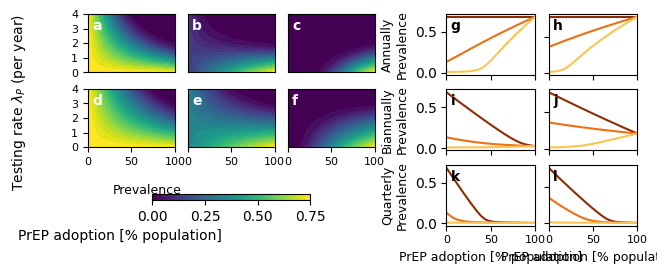

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.colors as mcolors
import matplotlib as mpl

# ------------------- Setup and Data ------------------------
results = np.load("../results/min_PrEP_prevalance.npy", allow_pickle=True).item()
beta_STI_values = [5 * 0.0016, 7 * 0.0016]
num_Hs = 101
num_Ps = 201
Hs = np.linspace(0, 0.2, num_Hs)
Ps = np.linspace(0, 1, num_Ps)
fixed_H_indexes = [0, 20, 50]
colors = ["#8c2d04", "#ec7014", "#fec44f"]

def discretize_cmaps(cmap, N):
    cmap = plt.colormaps[cmap]
    colors = cmap(np.linspace(0, 1, N))
    res = ListedColormap(colors)
    res.set_bad("#ABABAB")
    return res

cmap = discretize_cmaps("viridis", 25)

# For the right grid "line" plots
lambda_P_values = [20000, 10000, 0] 
lambda_P_labels = [ "Annually", "Biannually", "Quarterly"]
colors_R0 = ["#8c2d04", "#ec7014", "#fec44f"]

# ---------------- Figure layout ---------------------- 
fig = plt.figure(figsize=(7.09, 2.75))
outer_grid = GridSpec(1, 2, width_ratios=[6, 4], wspace=0.3, figure=fig)

# LEFT: 2x3 grid in the left panel (60%)
left_grid = GridSpecFromSubplotSpec(
    2, 3, subplot_spec=outer_grid[0], hspace=0.28, wspace=0.15
)
axes_left = []
for i in range(2):
    for j in range(3):
        ax = fig.add_subplot(left_grid[i, j])
        axes_left.append(ax)

# RIGHT: 3x2 grid in the right panel (40%)
right_grid = GridSpecFromSubplotSpec(
    3, 2, subplot_spec=outer_grid[1], hspace=0.24, wspace=0.15
)
axes_right = []
for i in range(3):
    for j in range(2):
        ax = fig.add_subplot(right_grid[i, j])
        axes_right.append(ax)


# --------------- Left panel: imshow --------------------
for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, fixed_H_index in enumerate(fixed_H_indexes):
        ax = axes_left[row_idx*3 + col_idx]
        result_for_beta_STI = results[beta_STI]
        fixed_H_results = result_for_beta_STI[fixed_H_index, :, :]  # 2D matrix
        im = ax.imshow(
            fixed_H_results,
            aspect='auto',
            interpolation='nearest', 
            cmap=cmap, 
            extent=[0, 1, 4, 0]
        )
        # xaxis: bottom only
        if row_idx == 1:
            ax.set_xticks(np.linspace(0, 1, num=3))
            ax.set_xticklabels([int(Ps[0] * 100), int(Ps[100] * 100), int(Ps[200] * 100)], fontsize=8)
        else:
            ax.set_xticks([])
            ax.set_xticklabels([])
        # yaxis: left only
        if col_idx == 0:
            ax.set_yticks(np.linspace(0, 4, num=5))
            ax.set_yticklabels([4, 3, 2, 1, 0], fontsize=8)
        else:
            ax.set_yticks([])
            ax.set_yticklabels([])
        ax.grid(False)

# ------------ Right panel: line plots ---------------------
for row_i, lambda_P in enumerate(lambda_P_values):          # Each row: lambda_P
    for col_j, beta_STI in enumerate(beta_STI_values):      # Each column: beta_STI
        ax = axes_right[row_i * 2 + col_j]
        for h_idx, fixed_H_index in enumerate(fixed_H_indexes):
            result_for_beta_STI = results[beta_STI]
            fixed_H_value = result_for_beta_STI[fixed_H_index, lambda_P, :]
            ax.plot(Ps, fixed_H_value, color=colors[h_idx], label=f"H={Hs[fixed_H_index]:.2f}" if row_i==0 and col_j==1 else None)

        # Formatting for axes
        if row_i != len(lambda_P_values) - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xticks([0, 0.5, 1.0])
            ax.set_xticklabels(['0', '50', '100'], fontsize=8)
            ax.set_xlabel("PrEP adoption [% population]", fontsize=9)
        if col_j == 0:
            ax.set_ylabel(f"{lambda_P_labels[row_i]}\nPrevalence", fontsize=9)
        else:
            ax.set_yticklabels([])

        ax.set_xlim(Ps.min(), Ps.max())
        ax.grid(False)
        # Only add legend in the top-right subplot
        # if row_i == 0 and col_j == 1:
        #     ax.legend(fontsize=7, loc='upper right', frameon=True, framealpha=1)


# Optional: Add letters (a,b,c...) to subpanels for reference
for idx, ax in enumerate(axes_left):
    ax.text(0.05, 0.92, chr(97 + idx), transform=ax.transAxes,
            fontsize=10, fontweight="bold", va="top", ha="left", color="white")
    
for idx, ax in enumerate(axes_right):
    ax.text(0.05, 0.92, chr(97 + 6 + idx), transform=ax.transAxes,
            fontsize=10, fontweight="bold", va="top", ha="left", color="black")

# ----------- Colorbar below left grid ----------------------
orig_cmap = plt.get_cmap('viridis')
colors = orig_cmap(np.linspace(0,1,256))
colors[0] = [0,0,0,1]  # Black at the start
new_cmap = mcolors.ListedColormap(colors)
sm = mpl.cm.ScalarMappable(cmap=new_cmap, norm=mpl.colors.Normalize(vmin=0, vmax=0.75))
sm.set_array([])
cbar = fig.colorbar(sm,
                   ax=axes_left,
                   shrink=0.55, 
                   location='bottom',
                   aspect=27,
                   pad=0.22,
                   format=FuncFormatter(lambda x, pos: f"{x:.2f}"))
cbar.ax.set_ylabel("Prevalence", fontsize=9, rotation=0)

# General axis labels
fig.text(0.17, 0.06, "PrEP adoption [% population]", ha="center", fontsize=10)
fig.text(0.015, 0.56,
    'Testing rate $\lambda_P$ (per year)',
    va="center",
    rotation="vertical",
    fontsize=10)

# plt.tight_layout()
plt.show()
# fig.savefig("../figures/min_PrEP_plot_grid.pdf", format="pdf", bbox_inches="tight")

# For the 3D Plots

## Parameters of the system and basic function definitions

In [11]:
# Parameters
args, y0 = utils.read_params(filename="model_params_HIVandSTI.txt")


### Final Figure

In [ ]:
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1, 201)

# Define the specific values for lambda_P and beta_STI
#lambda_P_values = np.array([1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4]) /360
lambda_P_values = np.linspace(4/360, 0, 20001) #20001
beta_STI_values = np.array([5, 7]) * 0.0016

results = {}

# for beta_STI in beta_STI_values:
#     obSTI = args["beta_STI"]
#     args["beta_STI"] = beta_STI  # Override the beta_STI value in args

#     # Create a 3D NumPy array to store all results at once
#     results_array = np.zeros((len(Hs), len(lambda_P_values), len(Ps)))

#     # Convert P and H into mesh grids for batch computation
#     P_grid, H_grid = np.meshgrid(Ps, Hs, indexing='ij')

#     for idx, lambda_P in enumerate(lambda_P_values):
#         # Use np.vectorize to make these functions work with arrays
#         Ia_values = np.vectorize(msc.calculate_Ia)(P_grid, H_grid, args, lambda_P)
#         Is_values = np.vectorize(msc.calculate_Is)(P_grid, H_grid, args, lambda_P)

#         # Store the sum of Ia and Is (FIX: Transpose it to match expected shape)
#         results_array[:, idx, :] = (Ia_values + Is_values).T

#     # Store results in a dictionary for easy access (optional)
#     results[beta_STI] = results_array

#     args["beta_STI"] = obSTI  # Reset the beta_STI value




for beta_STI in beta_STI_values:
    obSTI = args["beta_STI"]
    args["beta_STI"] = beta_STI  # Override the beta_STI value in args
    for lambda_P in lambda_P_values:
        result = np.zeros((len(Hs), len(Ps)))
        for i, H in enumerate(Hs):
            for j, P in enumerate(Ps):
                m = msc.m(P,H,args)
                # lambda_a = msc.lambdaa(P, H, args, lambda_P)
                # lambda_s = msc.lambdas(P, H, args, lambda_P)
                # result[i, j] = (
                #     beta_STI
                #     * ((1 - m) * (1 - P) + P)
                #     * msc.calculate_S(P, H, args, lambda_P)
                #     * (
                #         msc.calculate_Ia(P, H, args, lambda_P)
                #         + msc.calculate_Is(P, H, args, lambda_P)
                #     )+ args["Sigma"]
                # )
                result[i, j] = msc.calculate_Ia(P, H, args, lambda_P) + msc.calculate_Is(P, H, args, lambda_P)
        results[(beta_STI, lambda_P)] = result
    args["beta_STI"] = obSTI  # Reset the beta_STI value in


utils.save_results(results, filename="min_PrEP_prevalance_loop")

INFO:tapm.utils:Results saved to ../results/min_PrEP_prevalance_loop.npy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib import rcParams

# Define parameter ranges
Hs = np.linspace(0, 0.2, 101)  # H values (frames for animation)
Ps = np.linspace(0, 1, 201)  # P values
lambda_P_values = np.linspace(4/360, 0, 2001)  # Reduced from 20,001 to 2,001
beta_STI_values = np.array([7]) * 0.0016  # Beta values

# Fake result dictionary for testing (use real data)
results = {(7 * 0.0016, lp): np.random.rand(len(Hs), len(Ps)) for lp in lambda_P_values}
results_prev = results.copy()

# Function to calculate min PrEP uptake dynamically (vectorized)
def calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps):
    min_PrEP_uptake_values = {}
    max_Y = []
    
    for beta_STI in beta_STI_values:
        min_uptakes_for_beta = np.zeros(len(lambda_P_values))
        max_Y_for_beta = np.zeros(len(lambda_P_values))
        
        for i, lambda_P in enumerate(lambda_P_values):
            if (beta_STI, lambda_P) in results:
                data = results[(beta_STI, lambda_P)]
                peak_indices = np.argmax(data, axis=1)  # Vectorized argmax across rows
                min_PrEP_uptake = Ps[peak_indices]  # Get P values at the peak
                
                min_uptakes_for_beta[i] = min_PrEP_uptake.mean()  # Use mean instead of looping
                max_Y_for_beta[i] = np.max(data)  # Maximum value directly

        min_PrEP_uptake_values[beta_STI] = min_uptakes_for_beta
        max_Y.append(max_Y_for_beta)
    
    return min_PrEP_uptake_values, np.array(max_Y)

# Precompute min PrEP uptake values before animation
min_PrEP_uptake_values, max_Y = calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={"projection": "3d"})

# Labels and settings function
def setup_axes(ax, title):
    ax.set_xlabel('P')
    ax.set_ylabel('$\\lambda_P$')
    ax.set_zlabel('cases')
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(["0", "0.5", "1"])
    ax.set_yticks([0/360, 1/360, 2/360, 3/360, 4/360])
    ax.set_yticklabels(["0/yr", "1/yr", "2/yr", "3/yr", "4/yr"])
    ax.set_title(title)

# Initialize scatter plots
sc1 = ax1.scatter([], [], [], c=[], cmap='viridis')
sc2 = ax2.scatter([], [], [], c=[], cmap='viridis')

# Function to update animation
def update(row_index):
    # Instead of clearing the entire plot, update existing scatter plot data
    setup_axes(ax1, f'New Cases (Hs={Hs[row_index]:.3f})')
    setup_axes(ax2, f'Prevalence (Hs={Hs[row_index]:.3f})')

    def update_subplot(ax, results, sc):
        x_values, y_values, z_values = [], [], []
        
        for (beta_STI, lambda_P), result in results.items():
            if beta_STI == 7 * 0.0016:
                x_values.extend(Ps)
                y_values.extend(result[row_index, :])
                z_values.extend([lambda_P] * len(Ps))

        # Convert to NumPy arrays
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        z_values = np.array(z_values)

        # Update scatter plot data
        sc._offsets3d = (x_values, z_values, y_values)
        sc.set_array(y_values)

        # Plot min PrEP uptake values only once before animation
        for beta_STI in beta_STI_values:
            points_y = min_PrEP_uptake_values[beta_STI]
            colors = np.where(points_y < 1, 'red', 'black')
            ax.scatter(points_y, lambda_P_values, max_Y[0], c=colors, marker='o', label="Min PrEP Uptake")

        ax.legend()

    update_subplot(ax1, results, sc1)
    update_subplot(ax2, results_prev, sc2)

    return sc1, sc2

# Create animation
anim = animation.FuncAnimation(fig, update, frames=len(Hs), interval=50, blit=False)

# Save as a video file
rcParams['animation.ffmpeg_path'] = r"C:\Users\PMallick\ffmpeg-2025-02-17-git-b92577405b-essentials_build\ffmpeg-2025-02-17-git-b92577405b-essentials_build\bin\ffmpeg.exe"
anim.save('3D_comparison.mp4', writer=animation.FFMpegWriter(fps=10))


plt.show()


In [2]:
results = np.load("../results/min_PrEP.npy", allow_pickle=True).item()

results_prev = np.load("../results/min_PrEP_prevalance.npy", allow_pickle=True).item()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib import rcParams

# Define parameter ranges
Hs = np.linspace(0, 0.2, 101)  # H values (frames for animation)
Ps = np.linspace(0, 1, 201)  # P values
lambda_P_values = np.linspace(4/360, 0, 20001)[: 20]  # Lambda_P values
beta_STI_values = np.array([7]) * 0.0016  # Beta values

# Function to calculate min PrEP uptake dynamically
# def calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps, row_index):
#     min_PrEP_uptake_values = {}
#     max_Y = []
#     for beta_STI in beta_STI_values:
#         min_uptakes_for_beta = []
#         for lambda_P in lambda_P_values:
#             if (beta_STI, lambda_P) in results:  # Check if key exists
#                 data = results[(beta_STI, lambda_P)]
#                 if row_index < data.shape[0]:  # Ensure valid index
#                     Y = data[row_index, :]
#                     peak_index = np.argmax(Y)
#                     min_PrEP_uptake = Ps[peak_index]
#                     min_uptakes_for_beta.append(min_PrEP_uptake)
#                     max_Y.append(Y[peak_index])
#                 else:
#                     min_uptakes_for_beta.append(0)
#                     max_Y.append(0)
#             else:
#                 min_uptakes_for_beta.append(0)
#                 max_Y.append(0)
#         min_PrEP_uptake_values[beta_STI] = np.array(min_uptakes_for_beta)
#     return min_PrEP_uptake_values, max_Y

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={"projection": "3d"})

# Labels and settings function
def setup_axes(ax, title):
    ax.set_xlabel('P')
    ax.set_ylabel('$\\lambda_P$')
    ax.set_zlabel('cases')
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(["0", "0.5", "1"])
    ax.set_yticks([0/360, 1/360, 2/360, 3/360, 4/360])
    ax.set_yticklabels(["0/yr", "1/yr", "2/yr", "3/yr", "4/yr"])
    ax.set_title(title)

# Initialize scatter plots
sc1 = ax1.scatter([], [], [], c=[], cmap='viridis', label="New Cases")
sc2 = ax2.scatter([], [], [], c=[], cmap='viridis', label="Prevalance")

# Function to update animation
def update(row_index):
    ax1.clear()
    ax2.clear()
    
    # Set up both axes
    setup_axes(ax1, f'New Cases (Hs={Hs[row_index]:.3f})')
    setup_axes(ax2, f'Prevalence (Hs={Hs[row_index]:.3f})')

    # Function to update each subplot
    def update_subplot(ax, results, sc):
        x_values, y_values, z_values = [], [], []

        for (beta_STI, lambda_P), result in results.items():
            if beta_STI == 7 * 0.0016:
                x_values.extend(Ps)
                if row_index < result.shape[0]:
                    y_values.extend(result[row_index, :])
                else:
                    y_values.extend(np.zeros_like(Ps))
                z_values.extend([lambda_P] * len(Ps))

        x_values = np.array(x_values)
        y_values = np.array(y_values)
        z_values = np.array(z_values)

        sc = ax.scatter(x_values, z_values, y_values, c=y_values, cmap='viridis')

        # # Compute min PrEP uptake values dynamically
        # min_PrEP_uptake_values, max_Y = calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps, row_index)

        # # Scatter plot for min PrEP uptake
        # for beta_STI in beta_STI_values:
        #     points_y = min_PrEP_uptake_values[beta_STI]
        #     colors = ['red' if p < 1 else 'black' for p in points_y]
        #     ax.scatter(points_y, lambda_P_values, max_Y, c=colors, marker='o', label="Min PrEP Uptake")

        # ax.legend()

    # Update both subplots
    update_subplot(ax1, results, sc1)
    update_subplot(ax2, results_prev, sc2)

    return sc1, sc2

# Create animation
anim = animation.FuncAnimation(fig, update, frames=len(Hs), interval=100)

# Save as a video file
rcParams['animation.ffmpeg_path'] = r"C:\Users\PMallick\ffmpeg-2025-02-17-git-b92577405b-essentials_build\ffmpeg-2025-02-17-git-b92577405b-essentials_build\bin\ffmpeg.exe"
anim.save('3D_comparison.mp4', writer=animation.FFMpegWriter(fps=10))

plt.show()


c:\Users\PMallick\miniconda3\envs\t_a_p_m\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\PMallick\miniconda3\envs\t_a_p_m\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


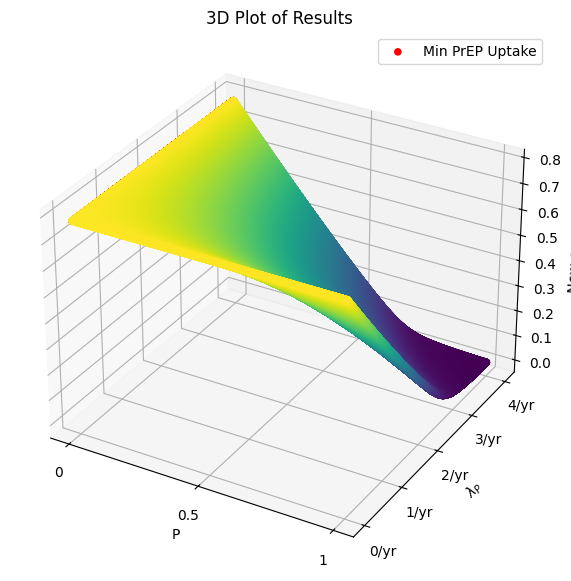

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'results' is defined
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1, 201)

# Define the specific values for lambda_P and beta_STI
lambda_P_values = np.linspace(4/360, 0, 20001)  # Downsample for speed
beta_STI_values = np.array([7]) * 0.0016

# Function to calculate min PrEP uptake dynamically
def calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps, row_index):
    min_PrEP_uptake_values = {}
    max_Y = []
    for beta_STI in beta_STI_values:
        min_uptakes_for_beta = []
        for lambda_P in lambda_P_values:
            if (beta_STI, lambda_P) in results:  # Check if key exists
                data = results[(beta_STI, lambda_P)]
                if row_index < data.shape[0]:  # Ensure valid index
                    Y = data[row_index, :] 
                    peak_index = np.argmax(Y)
                    min_PrEP_uptake = Ps[peak_index]
                    min_uptakes_for_beta.append(min_PrEP_uptake)
                    max_Y.append(Y[peak_index])  
                else:
                    min_uptakes_for_beta.append(0)
                    max_Y.append(0)
            else:
                min_uptakes_for_beta.append(0)
                max_Y.append(0)
        
        min_PrEP_uptake_values[beta_STI] = np.array(min_uptakes_for_beta)
    return min_PrEP_uptake_values, max_Y

def plot_3d(results_prev, row_index=0):
    global results, Ps  

    x_values = []
    y_values = []
    z_values = []

    # Collect data for the main 3D scatter plot
    for (beta_STI, lambda_P), result in results_prev.items():
        if beta_STI == 7 * 0.0016:
            x_values.extend(Ps)
            if row_index < result.shape[0]:
                y_values.extend(result[row_index, :])  
            else:
                y_values.extend(np.zeros_like(Ps))  
            z_values.extend([lambda_P] * len(Ps))
    
    x_values = np.array(x_values)
    y_values = np.array(y_values)
    z_values = np.array(z_values)
    
    # Create figure
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Main scatter plot
    sc = ax.scatter(x_values, z_values, y_values, c=y_values, cmap='viridis')
    
    # Labels and settings
    ax.set_xlabel('P')
    ax.set_ylabel('$\\lambda_P$')
    ax.set_zlabel('New cases')
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(["0", "0.5", "1"])
    ax.set_yticks([0/360, 1/360, 2/360, 3/360, 4/360])
    ax.set_yticklabels(["0/yr", "1/yr", "2/yr", "3/yr", "4/yr"])
    ax.set_title('3D Plot of Results')

    # Compute min PrEP uptake values dynamically
    min_PrEP_uptake_values, max_Y = calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results_prev, Ps, row_index)

    # Scatter plot for additional points with conditional coloring
    for beta_STI in beta_STI_values:
        points_y = min_PrEP_uptake_values[beta_STI]
        colors = ['red' if p < 1 else 'black' for p in points_y]  # Color based on condition
        ax.scatter(points_y, lambda_P_values, max_Y, c=colors, marker='o', label="Min PrEP Uptake", zorder=10)

    ax.legend()
    #plt.show()

# Call the function with a specific row_index
plot_3d(results_prev=results_prev, row_index=0)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: 'C:\Users\PMallick\ffmpeg-2025-02-17-git-b92577405b-essentials_build\ffmpeg-2025-02-17-git-b92577405b-essentials_build\bin\ffmpeg.exe' -f rawvideo -vcodec rawvideo -s 1000x700 -pix_fmt rgba -framerate 10 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y 3D_prevalence_2.mp4


MemoryError: Unable to allocate 123. MiB for an array with shape (4020201, 4) and data type float64

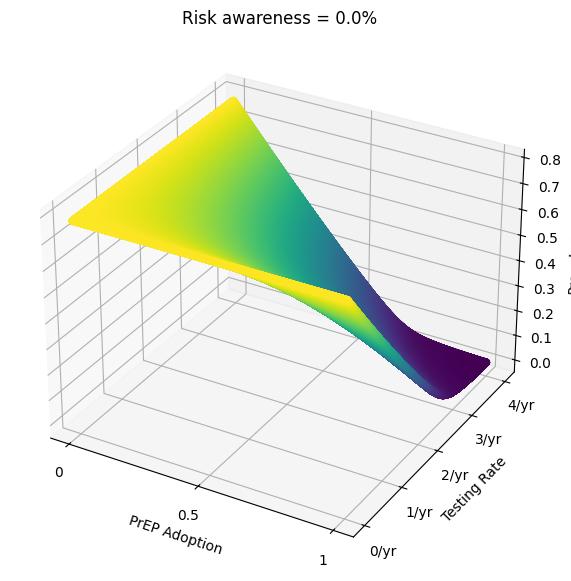

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib import rcParams

results = np.load("../results/min_PrEP_prevalance_loop.npy", allow_pickle=True).item()

# Assuming 'results' is defined
Hs = np.linspace(0, 0.2, 101)  # H values
Ps = np.linspace(0, 1, 201)
lambda_P_values = np.linspace(4/360, 0, 20001)  # Downsample for speed
beta_STI_values = np.array([7]) * 0.0016

# Function to calculate min PrEP uptake dynamically
def calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps, row_index):
    min_PrEP_uptake_values = {}
    max_Y = []
    for beta_STI in beta_STI_values:
        min_uptakes_for_beta = []
        for lambda_P in lambda_P_values:
            if (beta_STI, lambda_P) in results:  # Check if key exists
                data = results[(beta_STI, lambda_P)]
                if row_index < data.shape[0]:  # Ensure valid index
                    Y = data[row_index, :]
                    peak_index = np.argmax(Y)
                    min_PrEP_uptake = Ps[peak_index]
                    min_uptakes_for_beta.append(min_PrEP_uptake)
                    max_Y.append(Y[peak_index])
                else:
                    min_uptakes_for_beta.append(0)
                    max_Y.append(0)
            else:
                min_uptakes_for_beta.append(0)
                max_Y.append(0)
        min_PrEP_uptake_values[beta_STI] = np.array(min_uptakes_for_beta)
    return min_PrEP_uptake_values, max_Y

# Create figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Labels and settings
ax.set_xlabel('PrEP Adoption')
ax.set_ylabel('Testing Rate')
ax.set_zlabel('Prevelence')
ax.set_xticks([0, 0.5, 1])
ax.set_xticklabels(["0", "0.5", "1"])
ax.set_yticks([0/360, 1/360, 2/360, 3/360, 4/360])
ax.set_yticklabels(["0/yr", "1/yr", "2/yr", "3/yr", "4/yr"])
#ax.set_title(f'Risk awareness = {Hs[row_index] * 100:.1f}%')

# Initialize scatter plots
sc = ax.scatter([], [], [], c=[], cmap='viridis', label="New Cases")
#min_prep_scatter = ax.scatter([], [], [], c=[], marker='o', label="Min PrEP Uptake")

def update(row_index):
    """Update the plot for the given row_index."""
    ax.clear()
    
    # Labels and settings
    ax.set_xlabel('PrEP Adoption')
    ax.set_ylabel('Testing Rate')
    ax.set_zlabel('Prevelence')
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(["0", "0.5", "1"])
    ax.set_yticks([0/360, 1/360, 2/360, 3/360, 4/360])
    ax.set_yticklabels(["0/yr", "1/yr", "2/yr", "3/yr", "4/yr"])
    ax.set_title(f'Risk awareness = {Hs[row_index] * 100:.1f}%')

    x_values = []
    y_values = []
    z_values = []

    # Collect data for the main 3D scatter plot
    for (beta_STI, lambda_P), result in results.items():
        if beta_STI == 7 * 0.0016:
            x_values.extend(Ps)
            if row_index < result.shape[0]:
                y_values.extend(result[row_index, :])
            else:
                y_values.extend(np.zeros_like(Ps))
            z_values.extend([lambda_P] * len(Ps))

    x_values = np.array(x_values)
    y_values = np.array(y_values)
    z_values = np.array(z_values)

    # Update main scatter plot
    sc = ax.scatter(x_values, z_values, y_values, c=y_values, cmap='viridis')

    # Compute min PrEP uptake values dynamically
    # min_PrEP_uptake_values, max_Y = calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps, row_index)

    # # Scatter plot for additional points with conditional coloring
    # for beta_STI in beta_STI_values:
    #     points_y = min_PrEP_uptake_values[beta_STI]
    #     colors = ['red' if p < 1 else 'black' for p in points_y]  # Black if 1, red otherwise
    #     ax.scatter(points_y, np.array(lambda_P_values), np.array(max_Y), c=colors, marker='o', label="Min PrEP Uptake")

    # ax.legend()
    return sc

# Create animation
anim = animation.FuncAnimation(fig, update, frames=len(Hs), interval=100)

# Save as a video file
rcParams['animation.ffmpeg_path'] = r"C:\Users\PMallick\ffmpeg-2025-02-17-git-b92577405b-essentials_build\ffmpeg-2025-02-17-git-b92577405b-essentials_build\bin\ffmpeg.exe"
anim.save('3D_prevalence_2.mp4', writer=animation.FFMpegWriter(fps=10))

plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

# Assuming 'results' is defined
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1, 201)

# Define the specific values for lambda_P and beta_STI
lambda_P_values = np.linspace(4/360, 0, 2001)  # Downsample for speed
beta_STI_values = np.array([7]) * 0.0016

def plot_3d(row_index=0):
    global results, Ps  

    x_values = []
    y_values = []
    z_values = []

    # Collect data for the main 3D scatter plot
    for (beta_STI, lambda_P), result in results_prev.items():
        if beta_STI == 7 * 0.0016:
            x_values.extend(Ps)
            if row_index < result.shape[0]:
                y_values.extend(result[row_index, :])  
            else:
                y_values.extend(np.zeros_like(Ps))  
            z_values.extend([lambda_P] * len(Ps))

    x_values = np.array(x_values)
    y_values = np.array(y_values)
    z_values = np.array(z_values)
    
    # Create figure
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Main scatter plot
    sc = ax.scatter(x_values, z_values, y_values, c=y_values, cmap='viridis')
    
    # Labels and settings
    ax.set_xlabel('P')
    ax.set_ylabel('$\\lambda_P$')
    ax.set_zlabel('New cases')
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(["0", "0.5", "1"])
    ax.set_yticks([0/360, 1/360, 2/360, 3/360, 4/360])
    ax.set_yticklabels(["0/yr", "1/yr", "2/yr", "3/yr", "4/yr"])
    ax.set_title('3D Plot of Results')

    # Function to calculate min PrEP uptake dynamically
    def calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps, row_index):
        min_PrEP_uptake_values = {}
        max_Y = []

        for beta_STI in beta_STI_values:
            min_uptakes_for_beta = []
            for lambda_P in lambda_P_values:
                if (beta_STI, lambda_P) in results:  # Check if key exists
                    data = results[(beta_STI, lambda_P)]
                    if row_index < data.shape[0]:  # Ensure valid index
                        Y = data[row_index, :] 
                        peak_index = np.argmax(Y)
                        min_PrEP_uptake = Ps[peak_index]
                        min_uptakes_for_beta.append(min_PrEP_uptake)
                        max_Y.append(Y[peak_index])  
                    else:
                        min_uptakes_for_beta.append(0)
                        max_Y.append(0)
                else:
                    min_uptakes_for_beta.append(0)
                    max_Y.append(0)
            
            min_PrEP_uptake_values[beta_STI] = np.array(min_uptakes_for_beta)
            
        return min_PrEP_uptake_values, max_Y

    # Compute min PrEP uptake values dynamically
    min_PrEP_uptake_values, max_Y = calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results_prev, Ps, row_index)

    # Scatter plot for additional points with conditional coloring
    for beta_STI in beta_STI_values:
        points_y = min_PrEP_uptake_values[beta_STI]
        colors = ['red' if p < 1 else 'black' for p in points_y]  # Color based on condition
        ax.scatter(points_y, np.array(lambda_P_values), np.array(max_Y), c=colors, marker='o', label="Min PrEP Uptake")

    ax.legend()
    plt.show()

# Create the interactive slider
interact(plot_3d, row_index=(0, 100, 1))


interactive(children=(IntSlider(value=0, description='row_index'), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_3d(row_index=0)>

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

# Assuming 'results' is defined
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1, 201)

# Define the specific values for lambda_P and beta_STI
lambda_P_values = np.linspace(4/360, 0, 20001)  # Downsample for speed
beta_STI_values = np.array([7]) * 0.0016

def plot_3d(row_index=0):
    global results, Ps  

    x_values = []
    y_values = []
    z_values = []

    # Collect data for the main 3D scatter plot
    for (beta_STI, lambda_P), result in results_prev.items():
        if beta_STI == 7 * 0.0016:
            x_values.extend(Ps)
            if row_index < result.shape[0]:
                y_values.extend(result[row_index, :])  
            else:
                y_values.extend(np.zeros_like(Ps))  
            z_values.extend([lambda_P] * len(Ps))

    x_values = np.array(x_values)
    y_values = np.array(y_values)
    z_values = np.array(z_values)
    
    # Create figure
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Main scatter plot
    sc = ax.scatter(x_values, z_values, y_values, c=y_values, cmap='viridis')
    
    # Labels and settings
    ax.set_xlabel('P')
    ax.set_ylabel('$\\lambda_P$')
    ax.set_zlabel('New cases')
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(["0", "0.5", "1"])
    ax.set_yticks([0/360, 1/360, 2/360, 3/360, 4/360])
    ax.set_yticklabels(["0/yr", "1/yr", "2/yr", "3/yr", "4/yr"])
    ax.set_title('3D Plot of Results')

    # Labels and settings
    ax.set_xlabel('P')
    ax.set_ylabel('$\\lambda_P$')
    ax.set_zlabel('New cases')
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(["0", "0.5", "1"])
    ax.set_yticks([0/360, 1/360, 2/360, 3/360, 4/360])
    ax.set_yticklabels(["0/yr", "1/yr", "2/yr", "3/yr", "4/yr"])
    ax.set_title('3D Plot of Results')

    # Function to calculate min PrEP uptake dynamically
    def calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps, row_index):
        min_PrEP_uptake_values = {}
        max_Y = []

        for beta_STI in beta_STI_values:
            min_uptakes_for_beta = []
            for lambda_P in lambda_P_values:
                if (beta_STI, lambda_P) in results:  # Check if key exists
                    data = results[(beta_STI, lambda_P)]
                    if row_index < data.shape[0]:  # Ensure valid index
                        Y = data[row_index, :] 
                        peak_index = np.argmax(Y)
                        min_PrEP_uptake = Ps[peak_index]
                        min_uptakes_for_beta.append(min_PrEP_uptake)
                        max_Y.append(Y[peak_index])  
                    else:
                        min_uptakes_for_beta.append(0)
                        max_Y.append(0)
                else:
                    min_uptakes_for_beta.append(0)
                    max_Y.append(0)
            
            min_PrEP_uptake_values[beta_STI] = np.array(min_uptakes_for_beta)
            
        return min_PrEP_uptake_values, max_Y

    # Compute min PrEP uptake values dynamically
    min_PrEP_uptake_values, max_Y = calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results_prev, Ps, row_index)

    # Scatter plot for additional points with conditional coloring
    for beta_STI in beta_STI_values:
        points_y = min_PrEP_uptake_values[beta_STI]
        colors = ['red' if p < 1 else 'black' for p in points_y]  # Color based on condition
        ax.scatter(points_y, np.array(lambda_P_values), np.array(max_Y), c=colors, marker='o', label="Min PrEP Uptake")

        # Add vertical lines parallel to X and Y axes
        for px, py, pz in zip(points_y, lambda_P_values, max_Y):
            ax.plot([px, px], [py, py], [0, pz], color='gray', linestyle='dashed', alpha=0.5)  # Z-axis line
            ax.plot([px, px], [0, py], [pz, pz], color='gray', linestyle='dashed', alpha=0.5)  # Y-axis line
    
    ax.legend()
    plt.show()

# Create the interactive slider
interact(plot_3d, row_index=(0, 100, 1))


interactive(children=(IntSlider(value=0, description='row_index'), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_3d(row_index=0)>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

# Assuming 'results' is defined
# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1, 201)

# Define the specific values for lambda_P and beta_STI
lambda_P_values = np.linspace(4/360, 0, 20001)
beta_STI_values = np.array([5, 7]) * 0.0016

# Function to update the plot
def plot_3d(row_index=0):
    x_values = []
    y_values = []
    z_values = []

    for (beta_STI, lambda_P), result in results.items():
        if beta_STI == 7 * 0.0016:
            x_values.extend(Ps)
            if row_index < result.shape[0]:
                y_values.extend(result[row_index, :]) # Use the selected row index
            else:
                y_values.extend(np.zeros_like(Ps))  # Handle out of bounds
            z_values.extend([lambda_P] * len(Ps))

    x_values = np.array(x_values)
    y_values = np.array(y_values)
    z_values = np.array(z_values)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_values, z_values, y_values, c=y_values, cmap='viridis')
    ax.set_xlabel('P')
    ax.set_ylabel('$\\lambda_P$')
    ax.set_zlabel('New cases')
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(["1", "0.5", "0"])
    ax.set_yticks([0/360, 1/360, 2/360, 3/360, 4/360])
    ax.set_yticklabels(["0/yr", "1/yr", "2/yr", "3/yr", "4/yr"])
    ax.set_title('3D Plot of Results')
    plt.show()

# Create the interactive slider
interact(plot_3d, row_index=(0, 100, 1))


interactive(children=(IntSlider(value=0, description='row_index'), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_3d(row_index=0)>

<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
C:\Users\PMallick\AppData\Local\Temp\ipykernel_10940\784636970.py:69: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('$\lambda_P$')


201 20001 20001


C:\Users\PMallick\AppData\Local\Temp\ipykernel_10940\784636970.py:69: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('$\lambda_P$')


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (201,) and arg 1 with shape (20001,).

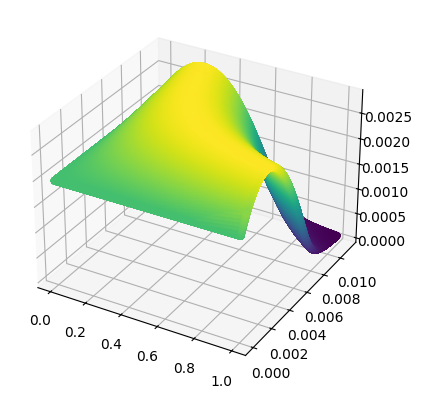

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps):
    min_PrEP_uptake_values = {}

    for beta_STI in beta_STI_values:
        for lambda_P in lambda_P_values:
            data = results[(beta_STI, lambda_P)]
            Y = data[0, :] 
            peak_index = np.argmax(Y)
            min_PrEP_uptake = Ps[peak_index]
            min_PrEP_uptake_values[(beta_STI, lambda_P)] = float("{:.4f}".format(min_PrEP_uptake))
            
    return min_PrEP_uptake_values

# Assuming that 'Ps' represents the x-axis values, 'lambda_P_values' represents the z-axis values,
# and 'results' contains results for each combination of beta_STI and lambda_P.

# Define the ranges for H and P values
Hs = np.linspace(0, 0.2, 101)
Ps = np.linspace(0, 1, 201)

# Define the specific values for lambda_P and beta_STI
#lambda_P_values = np.array([1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4]) /360
lambda_P_values = np.linspace(4/360, 0, 20001)
beta_STI_values = np.array([5, 7]) * 0.0016

min_PrEP_uptake_values = calculate_min_PrEP_uptake_values(beta_STI_values, lambda_P_values, results, Ps)

# Initialize lists for the axes values
x_values = []
y_values = []
z_values = []

# Iterate over the saved results
for (beta_STI, lambda_P), result in results.items():
    # Filter for beta_STI_values equal to 7 * 0.0016
    if beta_STI == 7 * 0.0016:
        # Store values for plotting
        x_values.extend(Ps)  # extend with all P values
        y_values.extend(result[0, :])  # extend with the first row of results
        z_values.extend([lambda_P] * len(Ps))  # repeat lambda_P value for each P

# Convert to numpy arrays for plotting
x_values = np.array(x_values)
y_values = np.array(y_values)
z_values = np.array(z_values)


# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
ax.scatter(x_values, z_values, y_values, c=y_values, cmap='viridis')

# Add the additional points
for beta_STI in beta_STI_values:
    beta_STI == 7 * 0.0016
    points_y = [min_PrEP_uptake_values[(beta_STI, lambda_P)] for lambda_P in lambda_P_values]
    print(len(Ps), len(points_y), len(lambda_P_values))
    ax.scatter(Ps, np.array(points_y), np.array(lambda_P_values), color='red', marker='o')


# Adding labels
ax.set_xlabel('P')
ax.set_ylabel('$\lambda_P$')
ax.set_zlabel('New cases')

# Adding ticks
ax.set_xticks([0, 0.5, 1])
ax.set_xticklabels(["1", "0.5", "0"])
ax.set_yticks([0/360, 1/360, 2/360, 3/360, 4/360])
ax.set_yticklabels(["0/yr", "1/yr", "2/yr", "3/yr", "4/yr"])


# Adding a title
ax.set_title('3D Plot of Results')

# Show the plot
plt.show()

In [4]:
print(len(x_values))
print(len(y_values))
print(len(z_values))

8040402
8040402
8040402


In [5]:
print(x_values)
print(y_values)
print(z_values)

[0.    0.005 0.01  ... 0.99  0.995 1.   ]
[0.00174342 0.00173358 0.00172304 ... 0.00197328 0.0019686  0.00196391]
[0.01111111 0.01111111 0.01111111 ... 0.         0.         0.        ]


In [4]:
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

# Prepare data for plotting
x_values = []  # P values
y_values = []  # result[0, :] values
z_values = []  # lambda_P values

# Iterate over the saved results
for (beta_STI, lambda_P), result in results.items():
    # Filter for beta_STI_values equal to 7 * 0.0016
    if beta_STI == 7 * 0.0016:
        # Store values for plotting
        x_values.extend(Ps)  # extend with all P values
        y_values.extend(result[0, :])  # extend with the first row of results
        z_values.extend([lambda_P] * len(Ps))  # repeat lambda_P value for each P

# Create a Plotly figure for 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x_values,
    y=z_values,
    z=y_values,
    mode='markers',
    marker=dict(
        size=5,
        color=y_values,  # Sets color to the y_values, could also use z_values if preferred
        colorscale='Viridis',
        opacity=0.8
    )
)])

# Update layout and add titles
fig.update_layout(
    title='Interactive 3D Scatter Plot of Results',
    scene=dict(
        xaxis_title='P',
        yaxis_title='lambda_P',
        zaxis_title='New cases'
    )
)

# Save the plot as an HTML file
fig.write_html("3D_Scatter_Plot.html")

# Show the interactive plot
fig.show()


In [5]:
# Determine the global vmin and vmax
all_infections = np.concatenate(
    [
        results[(beta_STI, lambda_P)].flatten()
        for beta_STI in beta_STI_values
        for lambda_P in lambda_P_values
    ]
)
global_vmin = np.min(all_infections)
global_vmax = np.max(all_infections)

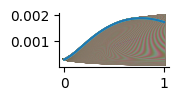

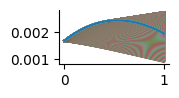

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(Lx, Ly))
indx_beta = 0
beta_STI = beta_STI_values[indx_beta]
for indx_lambda, lambda_P in enumerate(lambda_P_values):
    data = results[(beta_STI, lambda_P)]
    Y = data[25,:]
    ax.plot(Ps, Y, label="H = 0")
    #ax.set_xlim(0, 3)
    #ax.set_ylim(-0.003/100, 0.003)
    #ax.set_xticks([0, 1.5, 3])
    #ax.set_yticks([0, 0.0015, 0.003])
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #save the figure as a pdf. transparent=True makes the background transparent
    fig.savefig(f"../figures/fig_2_beta_1.pdf", transparent=True)

fig, ax = plt.subplots(1, 1, figsize=(Lx, Ly))
indx_beta = 1
beta_STI = beta_STI_values[indx_beta]
for indx_lambda, lambda_P in enumerate(lambda_P_values):
    data = results[(beta_STI, lambda_P)]
    Y = data[25,:]
    ax.plot(Ps, Y, label="H = 0")
    #ax.set_xlim(0, 3)
    #ax.set_ylim(-0.003/100, 0.003)
    #ax.set_xticks([0, 1.5, 3])
    #ax.set_yticks([0, 0.0015, 0.003])
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #save the figure as a pdf. transparent=True makes the background transparent
    fig.savefig(f"../figures/fig_2_beta_2.pdf", transparent=True)



        


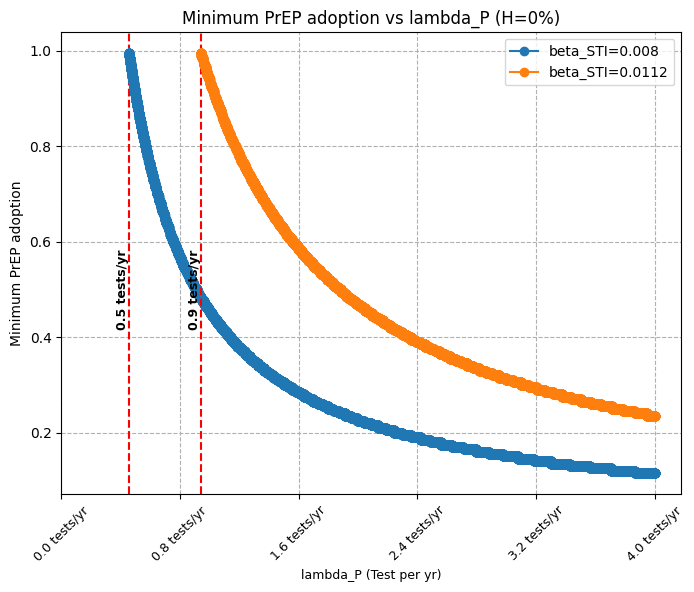

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a logarithmic model for fitting
def log_model(x, a, b):
    return a * np.log(x + 1e-6) + b

# Initialize dictionary to store minimum PrEP uptakes for each lambda_P
min_PrEP_uptakes = {}

for beta_STI in beta_STI_values:
    for lambda_P in lambda_P_values:
        data = results[(beta_STI, lambda_P)]
        Y = data[0, :]  # Data for H=0
        
        # Find the index of the maximum value (peak of the parabola)
        peak_index = np.argmax(Y)
        
        # Find the minimum PrEP uptake (x-coordinate of the peak)
        min_PrEP_uptake = Ps[peak_index]
        
        # Store the result
        min_PrEP_uptakes[(beta_STI, lambda_P)] = float("{:.4f}".format(min_PrEP_uptake))

# Prepare to plot
plt.figure(figsize=(8, 6))

for beta_STI in beta_STI_values:
    min_PrEP_uptake_values = [
        min_PrEP_uptakes[(beta_STI, lambda_P)] for lambda_P in lambda_P_values
    ]
    
    # Remove y=1 points
    lambda_P_values_cleaned = [lp for lp, y in zip(lambda_P_values, min_PrEP_uptake_values) if y < 1]
    min_PrEP_uptake_values_cleaned = [y for y in min_PrEP_uptake_values if y < 1]
    #print(lambda_P_values_cleaned)
    
    plt.axvline(x=lambda_P_values_cleaned[-2], color="red", linestyle="--")
    plt.text(
        lambda_P_values_cleaned[-2] + 0.00001, 0.5,
        f"{lambda_P_values_cleaned[-2]* 360:.1f} tests/yr",
        rotation=90, fontsize=9, verticalalignment="center", horizontalalignment="right", fontweight="bold"
    )
    
    # Plot the cleaned data
    plt.plot(lambda_P_values_cleaned[:-1], min_PrEP_uptake_values_cleaned[:-1], label=f"beta_STI={beta_STI}", marker="o")
    
    # Fit a logarithmic model for extrapolation
    # popt, _ = curve_fit(log_model, lambda_P_values_cleaned, min_PrEP_uptake_values_cleaned)
    # extrapolation_x_values = np.linspace(0, max(lambda_P_values_cleaned), 200)
    # extrapolated_y = log_model(extrapolation_x_values, *popt)
    # plt.plot(extrapolation_x_values, extrapolated_y, linestyle="--", alpha=0.5)



# Customize x-axis labels (convert lambda_P to test/year)
x_ticks = np.linspace(0, max(lambda_P_values), 6)  # Define tick positions
x_labels = [f"{x*360:.1f} tests/yr" for x in x_ticks]  # Convert to test/year for labels
plt.xticks(x_ticks, x_labels, fontsize=9, rotation=45)

# Customize plot
plt.xlabel("lambda_P (Test per yr)", fontsize=9)
plt.grid(which="major", linestyle="--")
plt.ylabel("Minimum PrEP adoption")
plt.title("Minimum PrEP adoption vs lambda_P (H=0%)")
# plt.vlines(1/360, -0.05, 1.05, colors="black", linestyles="--", label="lambda_P=1/yr")
# plt.vlines(2/360, -0.05, 1.05, colors="blue", linestyles="--", label="lambda_P=2/yr")
# plt.vlines(2.5/360, -0.05, 1.05, colors="green", linestyles="--", label="lambda_P=2.5/yr")
plt.legend()
plt.show()


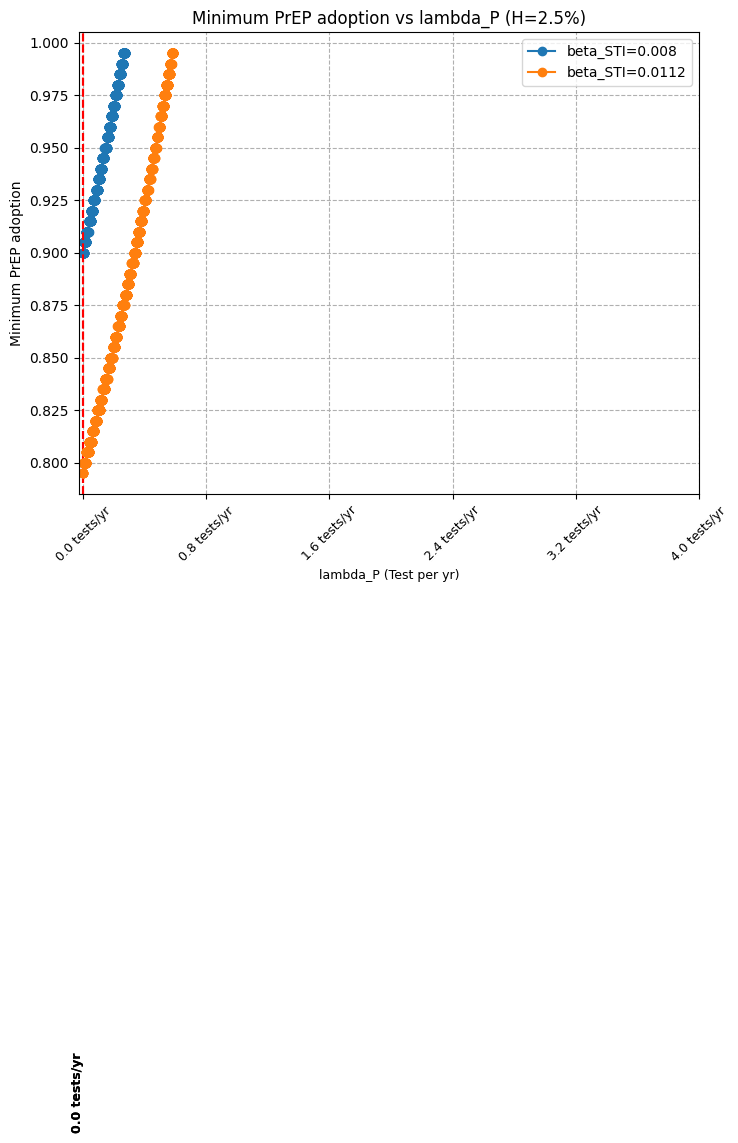

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a logarithmic model for fitting
def log_model(x, a, b):
    return a * np.log(x + 1e-6) + b

# Initialize dictionary to store minimum PrEP uptakes for each lambda_P
min_PrEP_uptakes = {}

for beta_STI in beta_STI_values:
    for lambda_P in lambda_P_values:
        data = results[(beta_STI, lambda_P)]
        Y = data[100, :]  # Data for H=0
        
        # Find the index of the maximum value (peak of the parabola)
        peak_index = np.argmax(Y)
        
        # Find the minimum PrEP uptake (x-coordinate of the peak)
        min_PrEP_uptake = Ps[peak_index]
        
        # Store the result
        min_PrEP_uptakes[(beta_STI, lambda_P)] = float("{:.4f}".format(min_PrEP_uptake))

# Prepare to plot
plt.figure(figsize=(8, 6))

for beta_STI in beta_STI_values:
    min_PrEP_uptake_values = [
        min_PrEP_uptakes[(beta_STI, lambda_P)] for lambda_P in lambda_P_values
    ]
    
    # Remove y=1 points
    lambda_P_values_cleaned = [lp for lp, y in zip(lambda_P_values, min_PrEP_uptake_values) if y < 1]
    min_PrEP_uptake_values_cleaned = [y for y in min_PrEP_uptake_values if y < 1]
    #print(lambda_P_values_cleaned)
    
    plt.axvline(x=lambda_P_values_cleaned[-2], color="red", linestyle="--")
    plt.text(
        lambda_P_values_cleaned[-2] + 0.00001, 0.5,
        f"{lambda_P_values_cleaned[-2]* 360:.1f} tests/yr",
        rotation=90, fontsize=9, verticalalignment="center", horizontalalignment="right", fontweight="bold"
    )
    
    # Plot the cleaned data
    plt.plot(lambda_P_values_cleaned[:-1], min_PrEP_uptake_values_cleaned[:-1], label=f"beta_STI={beta_STI}", marker="o")
    
    # Fit a logarithmic model for extrapolation
    # popt, _ = curve_fit(log_model, lambda_P_values_cleaned, min_PrEP_uptake_values_cleaned)
    # extrapolation_x_values = np.linspace(0, max(lambda_P_values_cleaned), 200)
    # extrapolated_y = log_model(extrapolation_x_values, *popt)
    # plt.plot(extrapolation_x_values, extrapolated_y, linestyle="--", alpha=0.5)



# Customize x-axis labels (convert lambda_P to test/year)
x_ticks = np.linspace(0, max(lambda_P_values), 6)  # Define tick positions
x_labels = [f"{x*360:.1f} tests/yr" for x in x_ticks]  # Convert to test/year for labels
plt.xticks(x_ticks, x_labels, fontsize=9, rotation=45)

# Customize plot
plt.xlabel("lambda_P (Test per yr)", fontsize=9)
plt.grid(which="major", linestyle="--")
plt.ylabel("Minimum PrEP adoption")
plt.title("Minimum PrEP adoption vs lambda_P (H=2.5%)")
# plt.vlines(1/360, -0.05, 1.05, colors="black", linestyles="--", label="lambda_P=1/yr")
# plt.vlines(2/360, -0.05, 1.05, colors="blue", linestyles="--", label="lambda_P=2/yr")
# plt.vlines(2.5/360, -0.05, 1.05, colors="green", linestyles="--", label="lambda_P=2.5/yr")
plt.legend()
plt.show()


beta_STI=0.008, lambda_P=0.006944444444444444: min_PrEP_uptake=0.18
beta_STI=0.008, lambda_P=0.006937499999999999: min_PrEP_uptake=0.18
beta_STI=0.008, lambda_P=0.006930555555555555: min_PrEP_uptake=0.18
beta_STI=0.008, lambda_P=0.00692361111111111: min_PrEP_uptake=0.18
beta_STI=0.008, lambda_P=0.0069166666666666664: min_PrEP_uptake=0.18
beta_STI=0.008, lambda_P=0.006909722222222222: min_PrEP_uptake=0.18
beta_STI=0.008, lambda_P=0.006902777777777778: min_PrEP_uptake=0.185
beta_STI=0.008, lambda_P=0.006895833333333333: min_PrEP_uptake=0.185
beta_STI=0.008, lambda_P=0.006888888888888889: min_PrEP_uptake=0.185
beta_STI=0.008, lambda_P=0.006881944444444444: min_PrEP_uptake=0.185
beta_STI=0.008, lambda_P=0.006875: min_PrEP_uptake=0.185
beta_STI=0.008, lambda_P=0.006868055555555555: min_PrEP_uptake=0.185
beta_STI=0.008, lambda_P=0.00686111111111111: min_PrEP_uptake=0.185
beta_STI=0.008, lambda_P=0.006854166666666666: min_PrEP_uptake=0.185
beta_STI=0.008, lambda_P=0.0068472222222222216: min_P

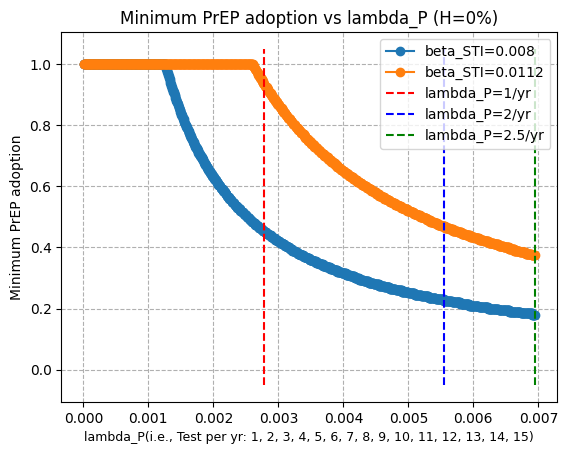

In [8]:
# Initialize dictionary to store minimum PrEP uptakes for each lambda_P
min_PrEP_uptakes = {}

for beta_STI in beta_STI_values:
    for lambda_P in lambda_P_values:
        data = results[(beta_STI, lambda_P)]
        # print(data)
        # Since we're interested in H=0, we use the first row (index 0)
        #print(Hs[50])
        Y = data[0, :]
        #derivative = np.gradient(Y, Ps)
        #print(derivative)
        # print(Y)
        
        # Find the index of the maximum value (peak of the parabola)
        peak_index = np.argmax(Y)
        #print(beta_STI, lambda_P)
        # print("Peak Index",peak_index)
        # print("Ps",Ps[peak_index])
        #print("Y",Y[peak_index], Y[peak_index-2], Y[peak_index-1], Y)
        
        # Find the minimum PrEP uptake (x-coordinate of the peak)
        min_PrEP_uptake = Ps[peak_index]
        # print(f"min_PrEP_uptake={min_PrEP_uptake}")
        
        # Store the result
        min_PrEP_uptakes[(beta_STI, lambda_P)] = float("{:.4f}".format(min_PrEP_uptake))

# Print or plot the results
for (beta_STI, lambda_P), min_PrEP_uptake in min_PrEP_uptakes.items():
    print(f"beta_STI={beta_STI}, lambda_P={lambda_P}: min_PrEP_uptake={min_PrEP_uptake}")


for beta_STI in beta_STI_values:
    min_PrEP_uptake_values = [min_PrEP_uptakes[(beta_STI, lambda_P)] for lambda_P in lambda_P_values]
    plt.plot(lambda_P_values[:-1], min_PrEP_uptake_values[:-1], label=f"beta_STI={beta_STI}", linestyle="-", marker="o")

plt.vlines(1/360, -0.05, 1.05, colors="red", linestyles="--", label="lambda_P=1/yr")
plt.vlines(2/360, -0.05, 1.05, colors="blue", linestyles="--", label="lambda_P=2/yr")
plt.vlines(2.5/360, -0.05, 1.05, colors="green", linestyles="--", label="lambda_P=2.5/yr")
plt.xlabel("lambda_P(i.e., Test per yr: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15)", fontsize=9)
plt.grid(which="major", linestyle="--")
plt.ylabel("Minimum PrEP adoption")
plt.title("Minimum PrEP adoption vs lambda_P (H=0%)")
#plt.axis([0, 0.045, -0.05, 1.05])   
plt.legend()
plt.show()
